Preprocessing

In [ ]:
# Import nessacary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import shap

Load the Data

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving final_feature_table.csv to final_feature_table.csv


Encoding Categorical Features

In [ ]:
df = pd.read_csv('final_feature_table.csv')

In [ ]:
# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=['Gene','MutationType'], drop_first=True)

Scale Numerical Features

In [ ]:
numerical_features = ['PolyPhen2_Score', 'SIFT_Score', 'Conservation_Score', 'AlleleFrequency']
scaler = StandardScaler()
df_encoded[numerical_features] = scaler.fit_transform(df_encoded[numerical_features])

Define Features

In [ ]:
X = df_encoded.drop('MobilitySeverity', axis=1)
y = df_encoded['MobilitySeverity']

Train/Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Class Imbalance

In [ ]:
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

Baseline Models

In [ ]:
log_reg = LogisticRegression(solver='liblinear', class_weight='balanced')
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

grid_lr = GridSearchCV(
    log_reg,
    param_grid_lr,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)
print("Best Logistic Regression Parameters:", grid_lr.best_params_)
print("Best Logistic Regression AUC:", grid_lr.best_score_)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Best Logistic Regression Parameters: {'C': 0.01, 'penalty': 'l1'}
Best Logistic Regression AUC: nan


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [ ]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_rf = GridSearchCV(
    rf_model,
    param_grid_rf,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)
print("Best Random Forest Parameters:", grid_rf.best_params_)
print("Best Random Forest AUC:", grid_rf.best_score_)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Best Random Forest Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Random Forest AUC: nan


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Evaluation

In [ ]:
# Logistic Regression Evaluation
best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)
y_pred_prob_lr = best_lr.predict_proba(X_test)[:, 1]

print("\nLogistic Regression Test Results:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob_lr))

# Random Forest Evaluation
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
y_pred_prob_rf = best_rf.predict_proba(X_test)[:, 1]

print("\nRandom Forest Test Results:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob_rf))


Logistic Regression Test Results:
Confusion Matrix:
 [[44 57]
 [ 0  0]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.44      0.61       101
           1       0.00      0.00      0.00         0

    accuracy                           0.44       101
   macro avg       0.50      0.22      0.30       101
weighted avg       1.00      0.44      0.61       101

ROC AUC: nan

Random Forest Test Results:
Confusion Matrix:
 [[101]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       101

    accuracy                           1.00       101
   macro avg       1.00      1.00      1.00       101
weighted avg       1.00      1.00      1.00       101

ROC AUC: nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: 

Plots

In [ ]:
def plot_roc_pr_curves(y_test, y_pred_prob, model_name="Model"):
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(12, 5))

    # ROC Curve Plot
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend(loc='lower right')

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='green')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} - Precision-Recall Curve')

    plt.tight_layout()
    plt.show()

Plot for Best Logistic Regression Model

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


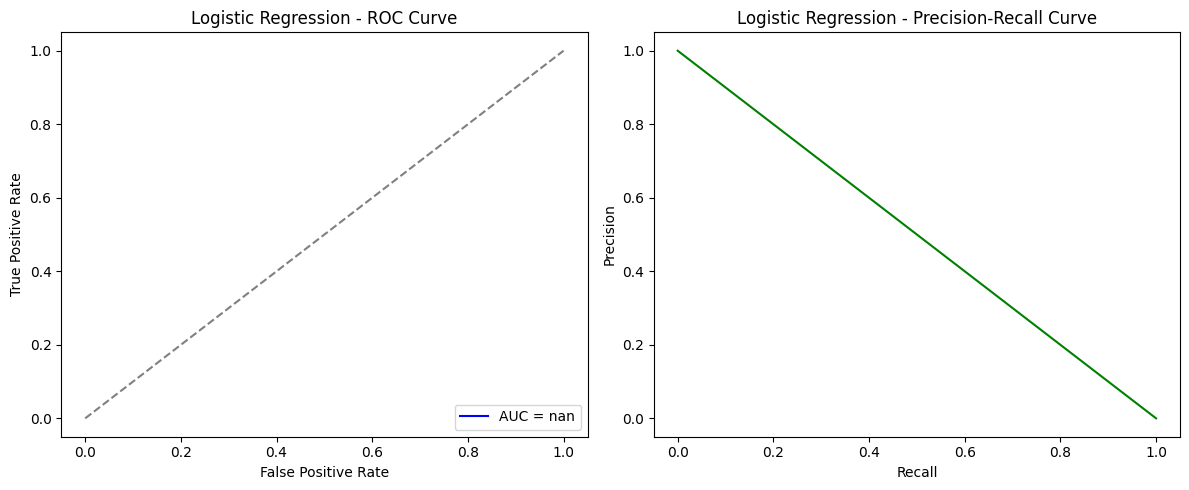

In [ ]:
plot_roc_pr_curves(y_test, y_pred_prob_lr, model_name="Logistic Regression")

Plot for Best Random Forest Model

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


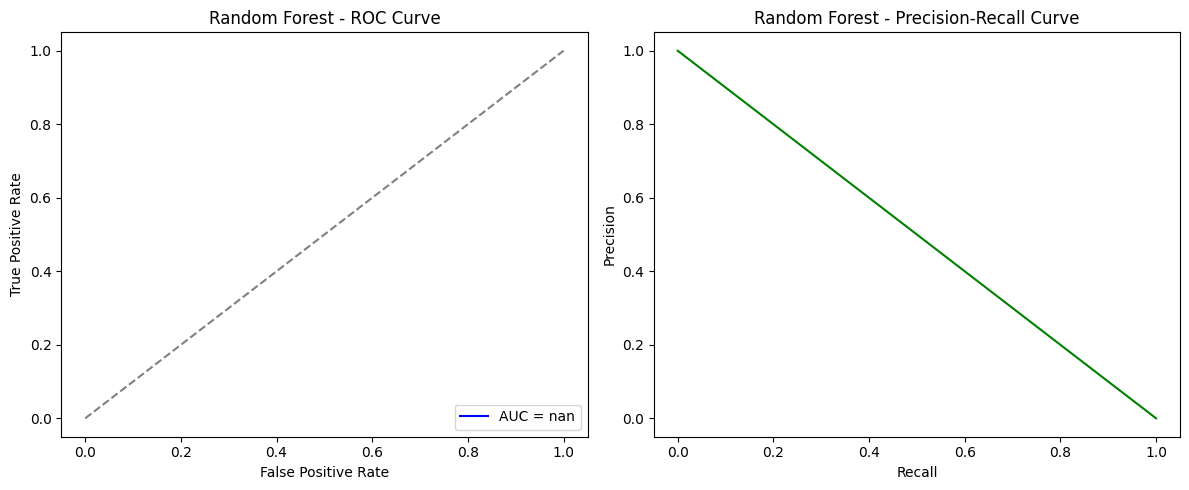

In [ ]:
plot_roc_pr_curves(y_test, y_pred_prob_rf, model_name="Random Forest")


Confusion Matrix Heatmaps

In [ ]:
def plot_confusion_matrix_heatmap(y_true, y_pred, model_name="Model"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

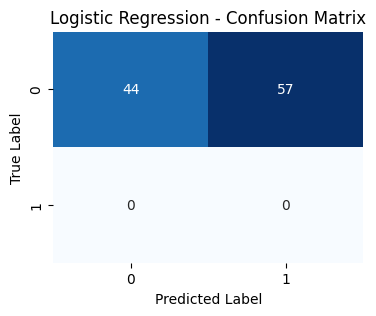

In [ ]:
plot_confusion_matrix_heatmap(y_test, y_pred_lr, model_name="Logistic Regression")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


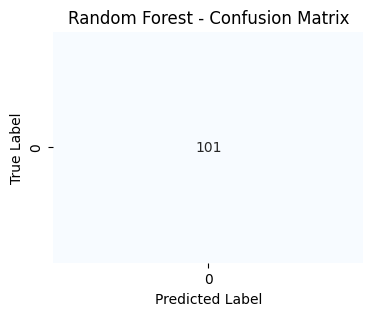

In [ ]:
plot_confusion_matrix_heatmap(y_test, y_pred_rf, model_name="Random Forest")


MLP Building

In [ ]:
# Define MLP architecture
model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


MLP Training

In [ ]:
# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    verbose=1
)


Class Weights: {0: np.float64(0.5025062656641605), 1: np.float64(100.25)}
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3048 - loss: 0.6322 - val_accuracy: 0.7778 - val_loss: 0.6299
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6204 - loss: 1.1280 - val_accuracy: 0.9630 - val_loss: 0.5369
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8204 - loss: 0.3632 - val_accuracy: 0.9877 - val_loss: 0.4625
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9131 - loss: 0.4015 - val_accuracy: 0.9877 - val_loss: 0.4185
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9547 - loss: 0.4691 - val_accuracy: 0.9877 - val_loss: 0.3772
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9800 - loss: 0.3048 - val_accuracy: 0.9877 - val_loss: 0.3381
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9639 - loss: 0.3984 - val_accuracy: 0.9877 - val_loss: 0.3040
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 

Evaluate the Model

In [ ]:
# Predict probabilities and binary labels
y_pred_prob_mlp = model.predict(X_test)
y_pred_mlp = (y_pred_prob_mlp > 0.5).astype(int)

# Evaluation metrics
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_mlp))
print("\nClassification Report:\n", classification_report(y_test, y_pred_mlp))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob_mlp))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Confusion Matrix:
 [[99  2]
 [ 0  0]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       101
           1       0.00      0.00      0.00         0

    accuracy                           0.98       101
   macro avg       0.50      0.49      0.49       101
weighted avg       1.00      0.98      0.99       101

ROC AUC Score: nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: 

Visualize the Training

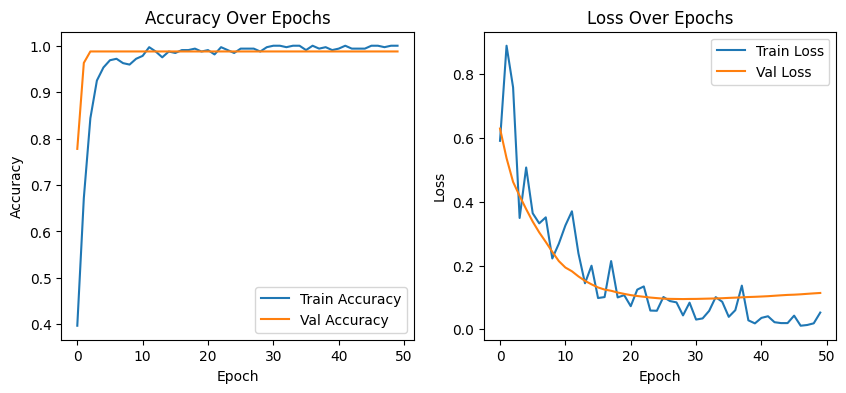

In [ ]:
 # Plot training history
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


SHAP

In [ ]:
# Convert to numpy for SHAP
X_train_np = X_train.to_numpy().astype('float32')
X_test_np = X_test.to_numpy().astype('float32')

# Create SHAP explainer for Keras MLP
explainer = shap.DeepExplainer(model, X_train_np)
shap_values = explainer.shap_values(X_test_np.astype('float32'))

/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(401, 8))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(802, 8))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(101, 8))']
  warnings.warn(msg)


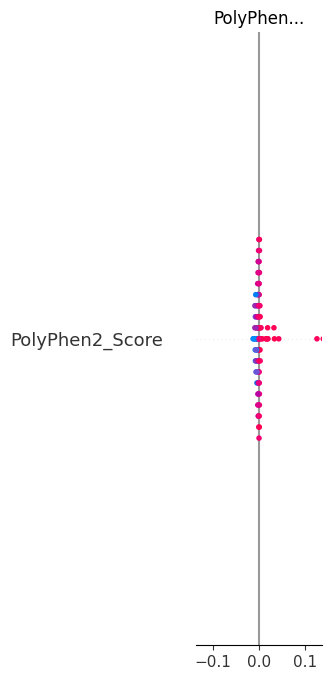

In [ ]:
# SHAP Summary Plot
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)
